In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

# FX 76-MP-140

## Aerofoil

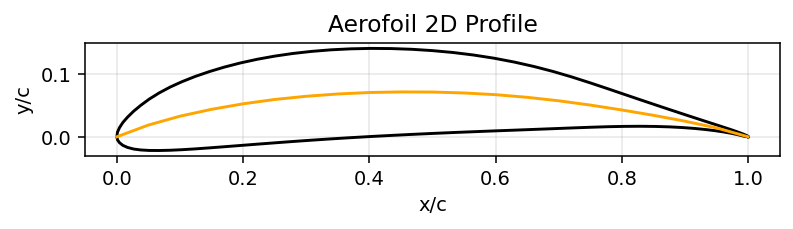

In [8]:
from carpy import geometry

fx76mp140 = geometry.NewAerofoil.from_url("http://airfoiltools.com/airfoil/lednicerdatfile?airfoil=fx76mp140-il")
fx76mp140.show()

## Performance

Reynolds number of interest

In [104]:
from carpy.environment import ISA1975
from carpy.utility import Quantity

atm = ISA1975()

altitude_m = 0
rho = atm.rho(altitude_m)
V = Quantity(10, "m s^{-1}")
L = Quantity(1, "m")
mu = atm.mu_visc(altitude_m)
Re = rho * V * L / mu

print(Re)

684582.81579933 


### Experiments

In [24]:
import pandas as pd

dfs = {"Run 1": None, "Run 2": None, "Run 3": None}

for key in dfs:
    # Use special encoding that supports temperature column (T <ordinal indicator> C)
    dfs[key] = pd.read_csv(f"./FX 76-MP-140 Dec 2023 {key}.csv", encoding="ISO-8859-1")

Take a look at lift and drag polars

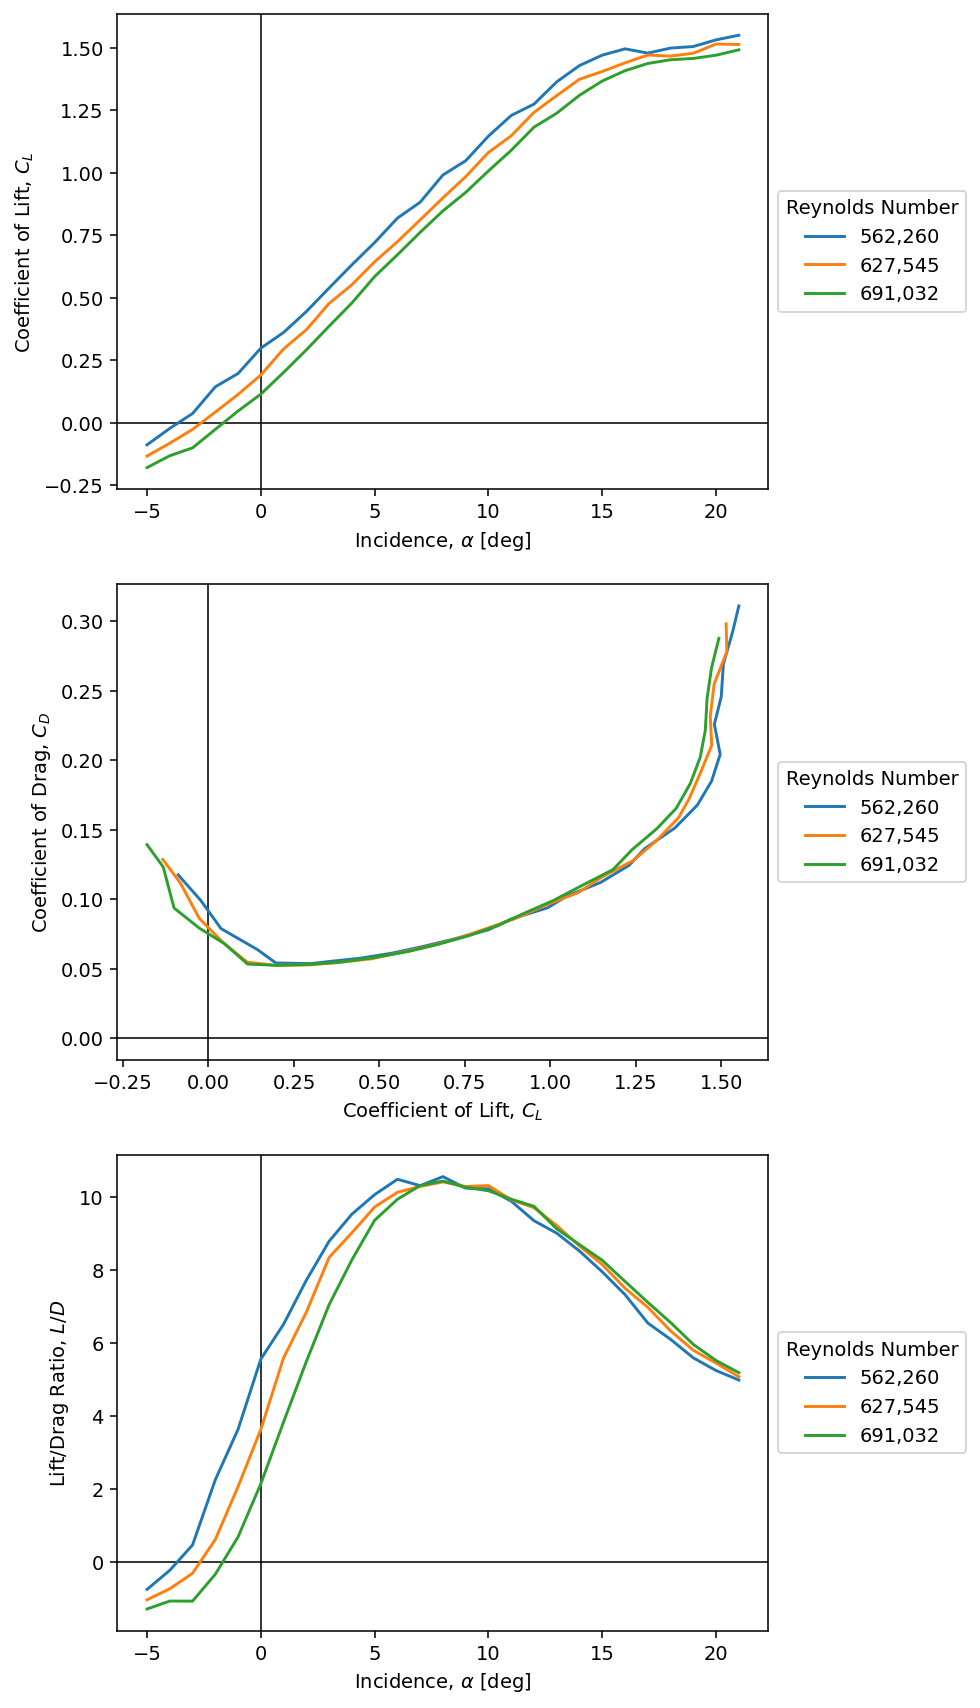

In [101]:
from matplotlib import pyplot as plt
from carpy.utility import constants as co

fig, axs = plt.subplots(3, 1, dpi=140, figsize=(6, 15))

chord = Quantity(50, "cm")
span = Quantity(5, "ft")
S = chord * span


for run_name, df in dfs.items():

    # Ignore any data points where the wind is off.
    df = df[~df["Comment"].fillna("").str.contains("Wind off")]
    df = df.dropna(axis=0, how="all")  # Drop empty rows

    lift = -df["Lift"]
    drag = df["Drag"]
    q = df["DynPr Pa"]
    V = df["Wind m/s"]
    T = Quantity(df["T ºC"], "degC")
    
    # Sutherland's law of kinematic viscosity
    mu = co.STANDARD.ISO_2533.betaS * T ** 1.5
    mu = mu / (T + co.STANDARD.ISO_2533.S)
    
    rho = q / (0.5 * V ** 2)
    Re = rho * V * chord / mu
    label = f"{Re.mean():,.0f}"
    
    cl = lift / (q * S)
    cd = drag / (q * S)

    # Lift-curve slope
    axs[0].plot(df["Incidence"], cl, label=label)
    axs[0].set_xlabel("Incidence, $\\alpha$ [deg]")
    axs[0].set_ylabel("Coefficient of Lift, $C_L$")

    # Drag polar
    axs[1].plot(cl, cd, label=label)
    axs[1].set_xlabel("Coefficient of Lift, $C_L$")
    axs[1].set_ylabel("Coefficient of Drag, $C_D$")

    # Lift/drag vs incidence
    axs[2].plot(df["Incidence"], cl/cd, label=label)
    axs[2].set_xlabel("Incidence, $\\alpha$ [deg]")
    axs[2].set_ylabel("Lift/Drag Ratio, $L/D$")
    
for ax in axs:
    ax.legend(bbox_to_anchor=(1, 0.5), loc="center left", title="Reynolds Number")
    ax.axhline(0, c="k", zorder=-10, lw=0.8)
    ax.axvline(0, c="k", zorder=-10, lw=0.8)